In [2]:
#### Creating layer: Number of previous fires

# Take image for a given fire scar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from rasterio.mask import mask
import rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from matplotlib import pyplot
from rasterio.warp import reproject, Resampling
from rasterio.transform import rowcol
from rasterio.windows import Window
from rasterio.merge import merge
from glob import glob
from shapely.geometry import mapping, box
from rasterio.features import geometry_mask
from rasterio.enums import Resampling

base_folder = "Fire_CL-ML_Maule"
output_dir = "merged_rasters"
os.makedirs(output_dir, exist_ok=True)

# perform cropping, padding and centering as in pre-processing 
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx") #excel meta-data file with file names and locations
df = df[df['FireScar'] == 1]  # Filter to just files that have fire scar available
df = df[df['Region_CONAF'] == 'Maule'] # Filter to just Maule
df = df.reset_index()

regions = gpd.read_file("Regiones/Regional.shp")
# Fix coordinate reference system 
regions = regions.to_crs("EPSG:4326")
maule_poly = regions[regions['Region'] == 'Región del Maule'] 
maule_geom = maule_poly.geometry.values

if maule_poly.empty:
    raise ValueError("No 'Maule' region found in shapefile.")


In [45]:
# Merge Mosaic by year, clipped to Maule

for year, group in df.groupby('FireSeason'):
    print(f"Processing year: {year}")

    # Use CRS and resolution from the first valid raster
    first_valid_path = None
    for _, row in group.iterrows():
        path = os.path.join(base_folder, row['FolderLocation'], row['FireScarImgName'])
        if os.path.exists(path):
            first_valid_path = path
            break
    if first_valid_path is None:
        print(f"No valid rasters found for year {year}")
        continue

    with rasterio.open(first_valid_path) as ref_src:
        ref_crs = ref_src.crs
        ref_res = ref_src.res

    # Reproject Maule polygon to raster CRS
    maule_geom_proj = maule_poly.to_crs(ref_crs)
    maule_bounds = maule_geom_proj.total_bounds
    minx, miny, maxx, maxy = maule_bounds

    # Define transform and shape for the base raster
    out_transform = rasterio.transform.from_origin(minx, maxy, ref_res[0], ref_res[1])
    width = int((maxx - minx) / ref_res[0])
    height = int((maxy - miny) / ref_res[1])

    # Create empty base raster filled with 0s
    base_array = np.zeros((height, width), dtype='float32')

    # Mask to only keep data inside Maule
    mask = geometry_mask([mapping(geom) for geom in maule_geom_proj.geometry],
                         transform=out_transform, invert=True,
                         out_shape=(height, width))

    # Loop over fire scar rasters
    for _, row in group.iterrows():
        scar_path = os.path.join(base_folder, row['FolderLocation'], row['FireScarImgName'])
        if not os.path.exists(scar_path):
            print(f"File not found: {scar_path}")
            continue

        try:
            with rasterio.open(scar_path) as src:
                src_data = src.read(1)
                src_data = np.where(src_data > 0, 1, 0).astype('float32')  # Ensure binary

                # Prepare destination array for reprojected image
                reprojected = np.zeros((height, width), dtype='float32')

                reproject(
                    source=src_data,
                    destination=reprojected,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=out_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.nearest
                )

                base_array += reprojected  # Add values
        except Exception as e:
            print(f"Could not read {scar_path}: {e}")

    # Cap to 1 for binary result
    base_array = np.clip(base_array, 0, 1)

    # Mask outside Maule, set to nan
    base_array[~mask] = np.nan 

    out_meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float32",
        "crs": ref_crs,
        "transform": out_transform,
        "nodata": np.nan
    }

    out_path = os.path.join(output_dir, f"Maule_FireScars_{year}.tif")
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(base_array, 1)

    print(f"Saved: {out_path}")


Processing year: 1986
Saved: merged_rasters/Maule_FireScars_1986.tif
Processing year: 1987
Saved: merged_rasters/Maule_FireScars_1987.tif
Processing year: 1988
Saved: merged_rasters/Maule_FireScars_1988.tif
Processing year: 1989
Saved: merged_rasters/Maule_FireScars_1989.tif
Processing year: 1990
Saved: merged_rasters/Maule_FireScars_1990.tif
Processing year: 1991
Saved: merged_rasters/Maule_FireScars_1991.tif
Processing year: 1992
Saved: merged_rasters/Maule_FireScars_1992.tif
Processing year: 1993
Saved: merged_rasters/Maule_FireScars_1993.tif
Processing year: 1994
Saved: merged_rasters/Maule_FireScars_1994.tif
Processing year: 1995
Saved: merged_rasters/Maule_FireScars_1995.tif
Processing year: 1996
Saved: merged_rasters/Maule_FireScars_1996.tif
Processing year: 1997
Saved: merged_rasters/Maule_FireScars_1997.tif
Processing year: 1998
Saved: merged_rasters/Maule_FireScars_1998.tif
Processing year: 1999
Saved: merged_rasters/Maule_FireScars_1999.tif
Processing year: 2000
Saved: merge

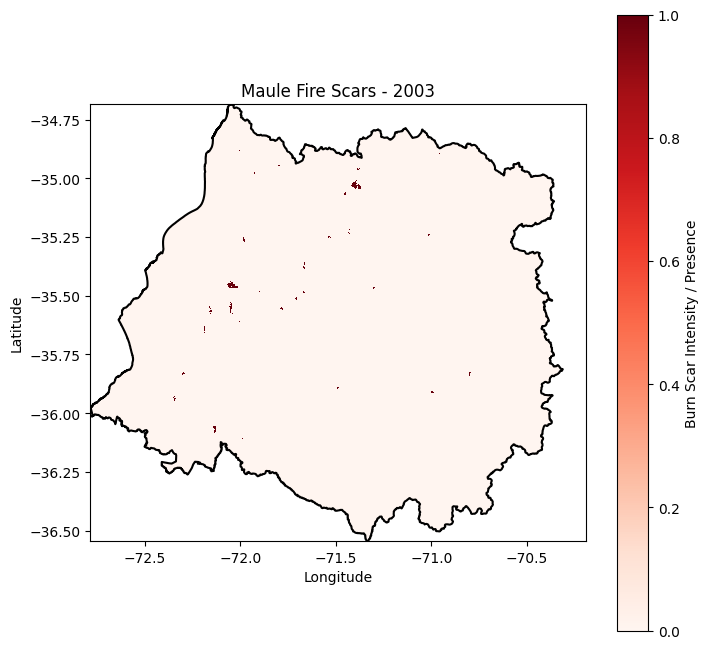

In [50]:
raster_path = "merged_rasters/Maule_FireScars_2010.tif"
# Visualize example
# Open and plot
with rasterio.open(raster_path) as src:
    data = src.read(1) 
    raster_crs = src.crs
    raster_bounds = src.bounds

    maule_poly = maule_poly.to_crs(raster_crs)

    extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top] # For formating plot

    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='Reds', interpolation='none', extent=[raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top])
    plt.colorbar(label="Burn Scar Intensity / Presence")
    plt.title("Maule Fire Scars - 2003")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Plot Maule border
    maule_poly.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1.5)

    plt.grid(False)
    plt.show()
    

In [ ]:
### Now, create a 

True

In [27]:
raster_crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [52]:
# 10 year fire history

# Create merged mosaic of year by adding previous 10 years, excluding current year (represent # previous fires in past 10 years)
output_dir = "prev10_rasters"
input_dir = 'merged_rasters'
os.makedirs(output_dir, exist_ok=True)

# Get sorted list of available years
tif_files = sorted(glob(os.path.join(input_dir, "Maule_FireScars_*.tif")))
available_years = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in tif_files]

# Map from year to filepath
year_to_path = {int(os.path.basename(f).split('_')[-1].split('.')[0]): f for f in tif_files}

# Loop over years and create "previous 10 years" raster
for year in available_years:
    # Get the previous 10 years
    prev_years = [y for y in range(year - 10, year) if y in year_to_path]
    if not prev_years:
        print(f"Skipping {year}: No previous rasters available.")
        continue

    print(f"Processing: {year} (using {len(prev_years)} previous years)")

    # Open the first raster to get metadata and shape
    with rasterio.open(year_to_path[prev_years[0]]) as src:
        out_meta = src.meta.copy()
        data_sum = src.read(1).astype('float32')
        data_sum[np.isnan(data_sum)] = 0  # Treat NaNs as 0

    # Sum the other rasters
    for y in prev_years[1:]:
        with rasterio.open(year_to_path[y]) as src:
            data = src.read(1).astype('float32')
            data[np.isnan(data)] = 0
            data_sum += data

    # Keep NaNs where they were originally masked (i.e., outside Maule)
    with rasterio.open(year_to_path[prev_years[0]]) as ref_src:
        mask = ref_src.read(1)
        data_sum[np.isnan(mask)] = np.nan

    # Save the result
    out_path = os.path.join(output_dir, f"Maule_Prev10FireScars_{year}.tif")
    out_meta.update({"dtype": "float32", "nodata": np.nan})
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(data_sum, 1)

    print(f"Saved: {out_path}")


Skipping 1986: No previous rasters available.
Processing: 1987 (using 1 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1987.tif
Processing: 1988 (using 2 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1988.tif
Processing: 1989 (using 3 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1989.tif
Processing: 1990 (using 4 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1990.tif
Processing: 1991 (using 5 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1991.tif
Processing: 1992 (using 6 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1992.tif
Processing: 1993 (using 7 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1993.tif
Processing: 1994 (using 8 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1994.tif
Processing: 1995 (using 9 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1995.tif
Processing: 1996 (using 10 previous years)
Saved: prev10_rasters/Maule_Prev10FireScars_1996.tif
Pro

In [17]:
# 30 year fire history: Frequency of fire occurrence (as a fraction)
# Constructed using Merged files from previous step

# Create merged mosaic of year by dividing the total number of fires by the total number of years considered
output_dir = "fire_history_rasters_30yr"
input_dir = 'merged_rasters'
os.makedirs(output_dir, exist_ok=True)

# Get sorted list of available years
tif_files = sorted(glob(os.path.join(input_dir, "Maule_FireScars_*.tif")))
available_years = [int(os.path.basename(f).split('_')[-1].split('.')[0]) for f in tif_files]

# Map from year to filepath
year_to_path = {int(os.path.basename(f).split('_')[-1].split('.')[0]): f for f in tif_files}

# Loop over years and create "previous 10 years" frequency raster
for year in available_years:
    # Get the previous 10 years
    prev_years = [y for y in range(year - 30, year) if y in year_to_path]
    if not prev_years:
        print(f"Skipping {year}: No previous rasters available.")
        continue

    print(f"Processing: {year} (using {len(prev_years)} previous years)")

    # Open the first raster to get metadata and initialize fire occurrence count
    with rasterio.open(year_to_path[prev_years[0]]) as src:
        out_meta = src.meta.copy()
        data_freq = np.zeros(src.shape, dtype='float32')  # Initialize frequency to 0
        mask = src.read(1)  # Read mask to preserve NaN areas
        data_freq[np.isnan(mask)] = np.nan  # Set NaN areas to NaN in the result

    # Count occurrences of fire in each raster
    for y in prev_years:
        with rasterio.open(year_to_path[y]) as src:
            data = src.read(1).astype('float32')
            data[np.isnan(data)] = 0  # Treat NaNs as 0 (no fire)
            data_freq += (data > 0).astype('float32')  # Increment frequency for pixels with fire

    # Compute the frequency a
    data_freq /= len(prev_years)  

    # Save the result as a frequency map 
    out_path = os.path.join(output_dir, f"Maule_FireFreq_{year}.tif")
    out_meta.update({"dtype": "float32", "nodata": np.nan})
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(data_freq, 1)

    print(f"Saved: {out_path}")


Skipping 1986: No previous rasters available.
Processing: 1987 (using 1 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1987.tif
Processing: 1988 (using 2 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1988.tif
Processing: 1989 (using 3 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1989.tif
Processing: 1990 (using 4 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1990.tif
Processing: 1991 (using 5 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1991.tif
Processing: 1992 (using 6 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1992.tif
Processing: 1993 (using 7 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1993.tif
Processing: 1994 (using 8 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1994.tif
Processing: 1995 (using 9 previous years)
Saved: fire_history_rasters_30yr/Maule_FireFreq_1995.tif
Processing: 1996 (using 10 previous years)
Saved: fire_history_

In [15]:
raster_path = "fire_history_rasters_30yr/Maule_FireFreq_2010.tif"

with rasterio.open(raster_path) as src:
    data = src.read(1) 
    print(np.nanmax(data))
    print(np.nanmin(data))
    print(np.nanmean(data))
    print(data.shape)

0.16666667
0.0
0.0006838777
(6898, 9180)


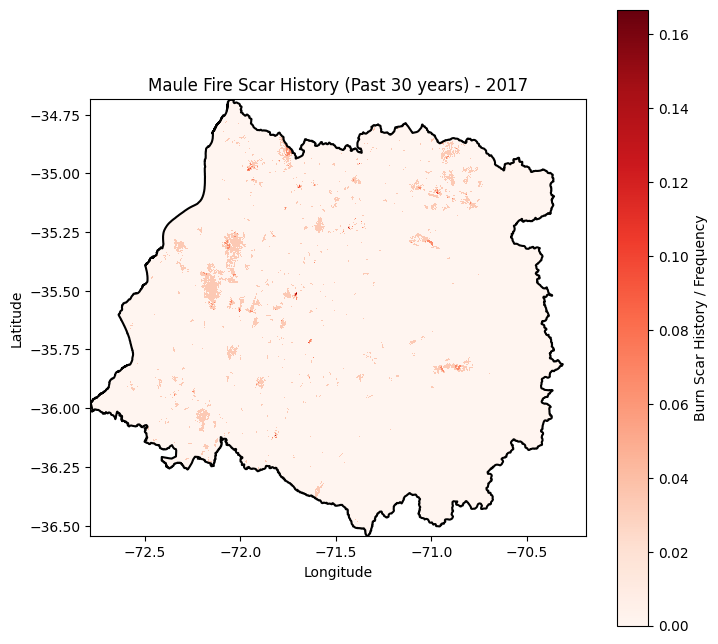

In [21]:
raster_path = "fire_history_rasters_30yr/Maule_FireFreq_2017.tif"
# Visualize example
# Open and plot
with rasterio.open(raster_path) as src:
    data = src.read(1) 
    raster_crs = src.crs
    raster_bounds = src.bounds

    maule_poly = maule_poly.to_crs(raster_crs)

    extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top] # For formating plot

    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='Reds', interpolation='none', extent=[raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top])
    plt.colorbar(label="Burn Scar History / Frequency")
    plt.title("Maule Fire Scar History (Past 30 years) - 2017")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Plot Maule border
    maule_poly.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1.5)

    plt.grid(False)
    plt.show()

In [ ]:
### Now create merged severity maps

# Merge Mosaic by year, clipped to Maule
output_dir = "merged_severity_rasters"
for year, group in df.groupby('FireSeason'):
    print(f"Processing year: {year}")

    # Use CRS and resolution from the first valid raster
    first_valid_path = None
    for _, row in group.iterrows():
        path = os.path.join(base_folder, row['FolderLocation'], row['SeverityImgName'])
        if os.path.exists(path):
            first_valid_path = path
            break
    if first_valid_path is None:
        print(f"No valid rasters found for year {year}")
        continue

    with rasterio.open(first_valid_path) as ref_src:
        ref_crs = ref_src.crs
        ref_res = ref_src.res

    # Reproject Maule polygon to raster CRS
    maule_geom_proj = maule_poly.to_crs(ref_crs)
    maule_bounds = maule_geom_proj.total_bounds
    minx, miny, maxx, maxy = maule_bounds

    # Define transform and shape for the base raster
    out_transform = rasterio.transform.from_origin(minx, maxy, ref_res[0], ref_res[1])
    width = int((maxx - minx) / ref_res[0])
    height = int((maxy - miny) / ref_res[1])

    # Create empty base raster filled with 0s
    base_array = np.zeros((height, width), dtype='float32')

    # Mask to only keep data inside Maule
    mask = geometry_mask([mapping(geom) for geom in maule_geom_proj.geometry],
                         transform=out_transform, invert=True,
                         out_shape=(height, width))

    # Loop over fire scar rasters
    for _, row in group.iterrows():
        scar_path = os.path.join(base_folder, row['FolderLocation'], row['FireScarImgName'])
        if not os.path.exists(scar_path):
            print(f"File not found: {scar_path}")
            continue

        try:
            with rasterio.open(scar_path) as src:
                src_data = src.read(1)

                # Prepare destination array for reprojected image
                reprojected = np.zeros((height, width), dtype='float32')

                reproject(
                    source=src_data,
                    destination=reprojected,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=out_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.nearest
                )

                base_array += reprojected  # Add values
        except Exception as e:
            print(f"Could not read {scar_path}: {e}")

    # Cap to 1 for binary result
    base_array = np.clip(base_array, 0, 1)

    # Mask outside Maule, set to nan
    base_array[~mask] = np.nan 

    out_meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float32",
        "crs": ref_crs,
        "transform": out_transform,
        "nodata": np.nan
    }

    out_path = os.path.join(output_dir, f"Maule_Severity_{year}.tif")
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(base_array, 1)

    print(f"Saved: {out_path}")


In [ ]:
### Merged ignition point maps